In [ ]:
import s3fs
import pandas as pd
fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})
MY_BUCKET = "jhajjar"
FILE_PATH_S3 = f"{MY_BUCKET}/Diffusion/post_processed_listings.csv"
with fs.open(FILE_PATH_S3, "r") as file_in:
    listings = pd.read_csv(file_in)

listings

,id,type,nb_pieces,loc,surface,prix
0,apimo-85473173,Appartement,1,Châtelet,29,364000
1,hektor-Les-4-Quartiers-383,Appartement,1,Châtelet,23,301000
2,hektor-PARISLUXURYHOMES-4007,Appartement,5,Palais Royal,106,2490000
3,ag754594-448898324,Studio,1,Saint-Germain,27,365000
4,keller-williams-1-34_1_53-180645,Appartement,2,Vendôme,67,1190000
...,...,...,...,...,...,...
8825,apimo-6951400,Appartement,4,Plaine,89,599000
8826,apimo-6810785,Appartement,2,Gambetta,40,302000
8827,immo-facile-49166437,Appartement,3,Père Lachaise,67,769000
8828,immo-facile-48762452,Appartement,3,Télégraphe,57,519000


Le dataframe issu du scraping comporte 8830 entrées et 6 variables.\
La variable "id" correspond à l'identifiant unique que le site donne à chaque annonce. Il est souvent composé du nom de l'agence immobilière et d'une suite de nombres.\
La variable "type" décrit le type du bien immobilier : appartement, maison, studio, hôtel, loft/atelier/surface.\
la variable "Nb_chambre" correspond au nombre de pièces dans le logement. Par "pièces" on entend une pièce principal comme une chambre, un salon par exemple. (la cuisine / salle de bains / toilettes / couloirs / entrée n'étant pas comptés).\
La variable "loc" indique la localisation du logement. Il ne s'agit pas d'une dénomination officielle mais de "sous-quartiers" arbitraires définis par un organisme nommé "Kelquartier", offrant des services d'informations aux plateformes immobilières.\
La variable "surface" est la superficie en mètre carré (loi Carrez) du logement. Finalement, la variable "prix" contient le prix en euros listé sur le site Bien'ici du bien immobilier en question.

Nous créons une colonne prix/surface (i.e. le prix au mètre carré) qui sera notre variable objective à estimer. De plus, à des fins de comparaison, analyser simplement le prix n'a pas vraiment de sens sans prendre en compte la surface du bien.

In [ ]:
listings.dropna(inplace=True)
listings["prix du m2"] = listings["prix"] / listings["surface"] #création de la colonne prix du m2

Afin de mieux appréhender notre dataframe, nous utilisons la fonction describe() de pandas. 

In [ ]:
description_listings = listings.describe()
description_formattée = description_listings.map(lambda x: f"{x:.2f}")  # écriture non scientifique et 2 chiffres après la virgule pour améliorer la clarté.
description_formattée

,nb_pieces,surface,prix,prix du m2
count,8830.00,8830.00,8830.00,8830.00
mean,2.88,68.40,792218.24,11013.54
std,1.86,53.17,878956.65,3540.78
min,1.00,4.00,22000.00,545.45
25%,2.00,33.00,330000.00,8950.00
50%,3.00,54.00,549040.00,10416.67
75%,4.00,87.00,900000.00,12307.69
max,90.00,699.00,20550000.00,52500.00


Avant d'interpréter les données, il est évident que plusieurs données résultent d'une anomalie/erreur de listing sur le site. En effet, une propriété contiendrait 90 pièces ce qui est impossible, surtout à Paris. Nous supprimons la ligne associée à cette erreur. De même le prix minimum de 22 0000 euros parait impossible pour les types de biens que nous avons retenu. Similairement, un prix du m2 de 545.54 n'est pas cohérent avec le marché parisien. 

In [ ]:
listings = listings.drop(index = listings['nb_pieces'].idxmax()) # supprime le maximum de la colonne "nb_pieces"
listings = listings.drop(index = listings['prix'].idxmin()) # supprime le minimum de la colonne "prix"
listings = listings.drop(index = listings['prix du m2'].idxmin()) #supprime le minimum de la colonne "prix du m2"

In [ ]:
def description_listings(listings : pd.DataFrame):
    description_listings = listings.describe()
    description_écrite = description_listings.map(lambda x: f"{x:.0f}")  # écriture non scientifique et arrondie à l'unité pour améliorer la clarté.
    description_formattée = description_listings.map(lambda x: f"{x:.2f}") # écriture non scientifique et 2 chiffres après la virgule pour améliorer la clarté.
    print(f"Le logement médian à Paris fait {description_écrite.loc['50%','surface']} m2, comporte {description_écrite.loc['50%','nb_pieces']} pièces et coûte {description_écrite.loc['50%','prix']}€ soit {description_écrite.loc['50%','prix du m2']}€ au m2")
    return description_formattée
description_listings(listings)

Le logement médian à Paris fait 54 m2, comporte 3 pièces et coûte 549080€ soit 10417€ au m2


,nb_pieces,surface,prix,prix du m2
count,8827.00,8827.00,8827.00,8827.00
mean,2.87,68.39,792244.83,11014.60
std,1.61,53.15,878944.65,3536.00
min,1.00,4.00,22000.00,956.52
25%,2.00,33.00,330000.00,8950.00
50%,3.00,54.00,549080.00,10416.67
75%,4.00,87.00,900000.00,12307.69
max,17.00,699.00,20550000.00,52500.00


Nous avons 8827 observations, une taille convenable pour pouvoir étudier les comportements statistiques asymptotiques et disposer d'une certaine représentativité du marché immobilier parisien.

Le nombre de pièces médian (3) et moyen (2.875) sont proches, ainsi, la distribution est centrée autour de trois pièces. Un immeuble représentatif parisien dispose (intuitivement) de deux chambres et un salon.

La surface moyenne et médiane sont quant à elles significativement éloignées. L'écart indique une distribution asymétrique vers la droite, quelques biens tirant la moyenne à la hausse. En effet un plancher minimal s'applique pour un bien immobilier (le minimum étant ici de 4 m2) tandis que le plafond peut être bien plus élevé (ici quasiment 700 m2 au maximum). D'un côte les studettes/locaux sont nombreux mais de l'autre les grands appartements haussmanniens et l'immobilier de luxe compensent largement.

Le même raisonnement peut être appliqué pour le prix où l'on observe un écart de quasiment 250 000 euros à la hausse ce qui indique que la distribution est fortement asymétrique vers la droite. On observe un écart type encore plus élevé que la moyenne qui dévoile une variabilité très importante dans les données. le prix du m2 (prix/surface) étant une fonction du prix, hérite de cette distribution asymétrique bien que dans une plus faible mesure.

Nous avons donc des distributions asymétriques à droite caractéristiques du marché immobilier parisien et que l'on retrouve dans d'autres centres économiques européens (comme Londres, Milan, Luxembourg, Munich, Genève).

 Afin de diminuer l'importance des valeurs extrêmes nous utilisons une transformation logarithmique pour le prix.

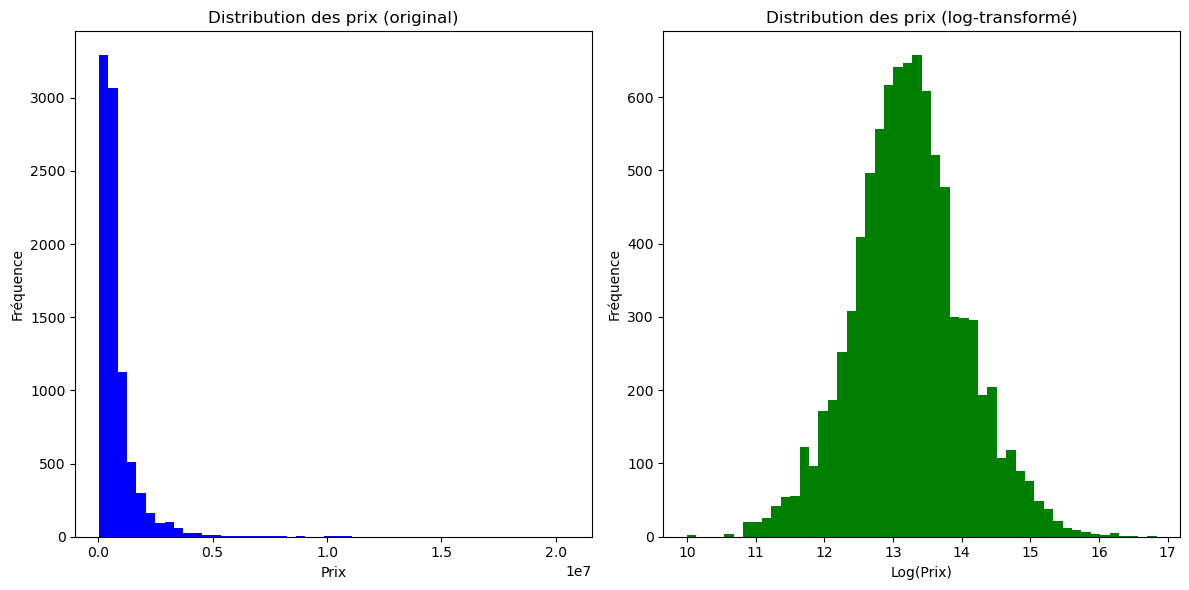

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
listings['log(prix)'] = np.log(listings['prix']) #transformation logarithmique grâce au np.log de numpy

import matplotlib.pyplot as plt

def graph_distribution_prix(listings: pd.DataFrame):
    """
    Trace les histogrammes de la distribution des prix avant et après transformation logarithmique.

    Args:
        listings (pd.DataFrame): DataFrame contenant les colonnes 'prix' et 'log(prix)'.
    """
    plt.figure(figsize=(12, 6))
    
    # Histogramme avant transformation
    plt.subplot(1, 2, 1)
    plt.hist(listings['prix'], bins=50, color='blue')
    plt.title('Distribution des prix (original)')
    plt.xlabel('Prix')
    plt.ylabel('Fréquence')
    
    # Histogramme après transformation
    plt.subplot(1, 2, 2)
    plt.hist(listings['log(prix)'], bins=50, color='green')
    plt.title('Distribution des prix (log-transformé)')
    plt.xlabel('Log(Prix)')
    plt.ylabel('Fréquence')
    
    plt.tight_layout()
    plt.show()

graph_distribution_prix(listings)


la log normalisation nous permet de passer d'une distribution fortement asymétrique à une distribution proche d'une gaussienne.

Procédons maintenant à l'analyse descriptive graphique de nos différentes variables.
Pour la variable surface, examinons la distribution du type de bien immobilier.

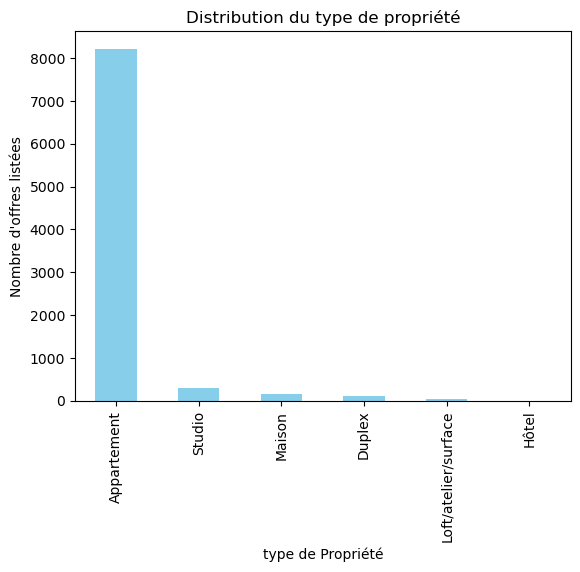

In [ ]:
def graph_distribution_type(listings: pd.DataFrame):

    nombre_de_types = listings['type'].value_counts()
    nombre_de_types.plot(kind='bar', color='skyblue')
    plt.title('Distribution du type de propriété')
    plt.xlabel('type de Propriété')
    plt.ylabel("Nombre d'offres listées")
    plt.show()

graph_distribution_type(listings)


Sans surprises, la grande majorité des biens offerts sont des appartements, héritages des travaux dirigés par le Baron Haussmann entre 1853 et 1870.  
Cependant les annonces étant remplies par des agences, elles sont sujettes à erreur, surtout pour la catégorisation des biens. Par exemple, pour les petites surfaces, on trouve un certain nombre de studios qui sont catégorisés en tant qu'appartements et inversement. La dénomination choisie de "studio" ne respecte souvent pas la réglementation française (une surface habitable minimale de 9m, une hauteur sous plafond d'au moins 2,20 mètres, un volume habitable d'au moins 20 m3).

Pour les autres types (hors Loft/atelier/surface), intuitivement, ils devraient ajouter de la valeur aux biens. En effet, posséder une maison à Paris raisonne avec exclusivité, de même pour un duplex et dans une encore plus grande mesure pour un hôtel particulier.

Pour le(s) hôtel(s) particulier(s), on peut se demander s'il est raisonnable de le(s) conserver car on ne cherchera pas à estimer un bien de ce type et il pourrait fausser la représentativité de nos appartements.

In [ ]:
listings[listings['type'] == 'Hôtel']

,id,type,nb_pieces,loc,surface,prix,prix du m2,log(prix)
829,ag751877-438736643,Hôtel,10,Notre Dame des Champs,646,10200000,15789.473684,16.137898


Il n'y a qu'un seul hôtel particulier et son prix du m2 est très élevé (bien au dessus du troisième quartile). Nous décidons de l'exclure afin de faciliter la modélisation

In [ ]:
listings = listings[listings['type'] != 'Hôtel']

In [ ]:
from scipy.stats import ttest_ind


prix_maisons = listings[listings['type'] == 'Maison']['log(prix)']
prix_duplex = listings[listings['type'] == 'Duplex']['log(prix)']
prix_appartements = listings[listings['type'] == 'Appartement']['log(prix)']
stat, p_value = ttest_ind(prix_maisons, prix_appartements, equal_var=False)
stat2, p_value2 = ttest_ind(prix_duplex, prix_appartements, equal_var=False)

print(f"Pour les Maisons : T-statistic: {stat}, P-value: {p_value}")
print(f"Pour les Duplex : T-statistic: {stat2}, P-value: {p_value2}")



Pour les Maisons : T-statistic: 14.746798485623708, P-value: 3.796915264011545e-31
Pour les Duplex : T-statistic: 8.861219450297183, P-value: 1.1470742214537283e-14


On observe des p.values inférieures à 1%, il y a bien une différence de prix significative entre les appartements d'un côté et les maisons et duplex de l'autre. En prenant en compte la surface des biens on observe que les moyennes sont très proches, et même, que celle des maisons est plus faible. Cela s'explique par le fait qu'un duplex ou une maison nécessite une surface plus grande ce qui, par mètre carré, compense le prix élevé.

In [ ]:
prix_par_type = listings.groupby('type')['prix du m2'].agg(['mean','median','count'])
prix_par_type


,mean,median,count
type,,,
Appartement,11013.579473,10400.000000,8217
Duplex,11738.753709,10825.490196,112
Loft/atelier/surface,9438.025224,9486.443381,46
Maison,10952.881843,9937.759336,148
Studio,11028.215486,10666.666667,303


La question se pose maintenant sur la catégorie Loft/atelier/surface. la moyenne du prix du m2 est de 9438€ soit près de 15% plus faible que la moyenne globale des biens immobiliers. En effet, un loft désigne communément un logement aux espaces ouverts issu d'un ancien atelier/entrepôt. Ces logements sont souvent moins chers au m2 car ils sont souvent destinés à faire office de bureaux/locaux commerciaux. De plus, le coût énergétique est souvent plus élevé (en raison des espaces ouverts). Bien qu'une partie d'entre eux peuvent être considérés comme appartenant à la catégorie appartement, nous ne pouvons pas filtrés plus précisément ces biens. Nous décidons ainsi de ...
OU afin d'éviter de prendre en compte des locaux commerciaux (mal catégorisés) nous décidons de supprimer les 10% valeurs les plus faibles. En effet, pour ces biens immobiliers, le prix est plus faible mais compensé par un loyer mensuel (à l'instar d'un viager).

In [ ]:
LAS_condition = listings['type'] == "Loft/atelier/surface"
LAS_listings = listings[LAS_condition]

seuil_quantile = LAS_listings['prix du m2'].quantile(0.10)

LAS_filtre = LAS_listings[LAS_listings['prix du m2'] > seuil_quantile]

autres_listings = listings[~LAS_condition]

#listings = pd.concat([loft_filtre, autres_listings], ignore_index=True)



In [ ]:

#listings = listings[listings["nb_pieces"]<50]
#listings["prix du m2 par pièce"] = listings["prix du m2"]/listings["nb_pieces"]
#quantile_sup_psp = listings["prix du m2 par pièce"].quantile(0.95)
#quantile_inf_psp = listings["prix du m2 par pièce"].quantile(0.05)
#quantile_sup_ps = listings["prix du m2"].quantile(0.95)
#quantile_inf_ps = listings["prix du m2"].quantile(0.05)
#quantile_sup_p = listings["surface"].quantile(0.97)
#quantile_inf_p = listings["surface"].quantile(0.05)
#print(quantile_inf_p)
#print(quantile_sup_p)
##listings = listings[(listings["prix du m2 par pièce"]>=quantile_inf_psp) & (listings["prix du m2 par pièce"]>=quantile_inf_psp)]
##listings = listings[(listings["prix du m2"]>=quantile_inf_ps) & (listings["prix du m2"]>=quantile_inf_ps)]
#listings = listings[(listings["surface"]<=quantile_sup_p)]
#pd.plotting.scatter_matrix(listings)
#listings[listings["nb_pieces"]>14]

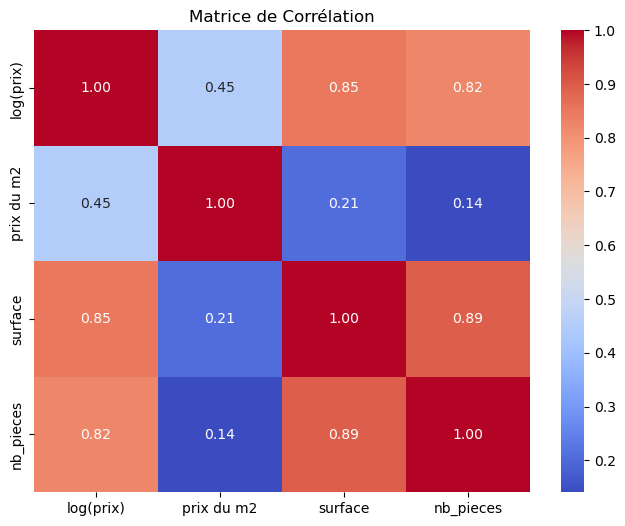

In [ ]:
import seaborn as sns


colonnes_numériques = ['log(prix)', 'prix du m2', 'surface', 'nb_pieces']

def graph_correlation_heatmap(listings: pd.DataFrame, numerical_cols: list):

    listings_numerique = listings[numerical_cols]
    matrice_corr = listings_numerique.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrice_corr, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Matrice de Corrélation")
    plt.show()

graph_correlation_heatmap(listings, colonnes_numériques)


Naturellement, le prix est corrélé positivement avec la surface du bien et son nombre de pièces. Pour le prix on observe une correlation forte, respectivement de 0.85 et 0.82. Intuitivement, si un bien est plus grand ou dispose de plus de pièces, il sera, toute chose égale par ailleurs, plus cher. Cependant, on observe que pour le prix du m2 les corrélations restent positives mais deviennent faibles (0.21 et 0.14 respectivement). Le fait que le prix du m2 soit corrélé positivement avec la surface suggère que l'augmentation du prix du bien surpasse l'augmentation de la surface. Ce phénomène peut paraître contre-intuitif pour certaines surfaces. Pour clarifier, nous analysons le coefficient de Pearson entre le prix/surface et la surface selon les quartiles de la surface.

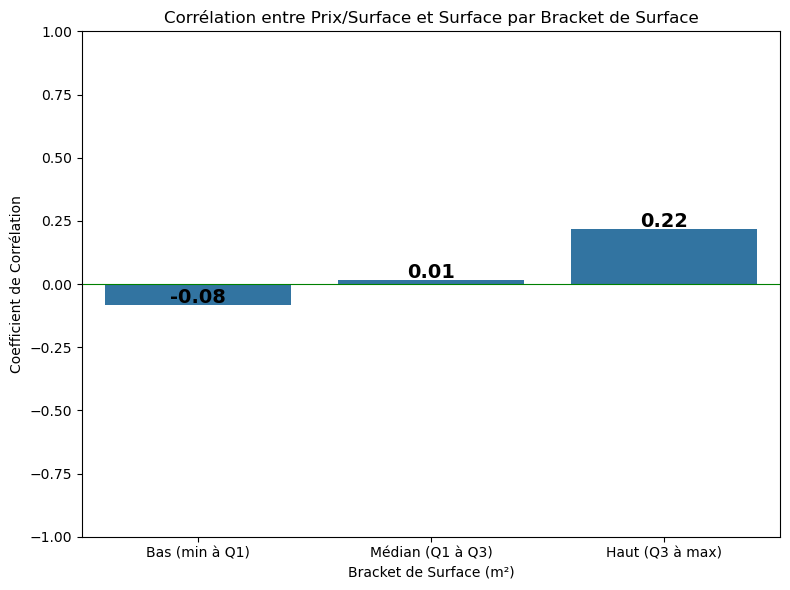

In [ ]:
# Supposons que 'listings' est votre DataFrame existant
# Exemple d'initialisation (à remplacer par vos données réelles)
# listings = pd.read_csv('votre_fichier.csv')
def graph_bar_correlation_bracket(listings: pd.DataFrame):
    """
    Trace la corrélation entre 'prix du m2' et 'surface' par brackets de surface.

    Args:
        listings (pd.DataFrame): DataFrame contenant les colonnes 'prix du m2' et 'surface'.
    """
    # Calcul des quartiles
    Q1 = listings['surface'].quantile(0.25)
    Q2 = listings['surface'].quantile(0.50)
    Q3 = listings['surface'].quantile(0.75)
    
    # Définition des brackets
    bins = [listings['surface'].min(), Q1, Q3, listings['surface'].max()]
    labels = ['Bas (min à Q1)', 'Médian (Q1 à Q3)', 'Haut (Q3 à max)']
    listings['surface_bracket'] = pd.cut(listings['surface'], bins=bins, labels=labels, include_lowest=True)
    listings['surface_bracket'] = listings['surface_bracket'].astype(pd.CategoricalDtype(categories=labels, ordered=True))
    
    # Nettoyage des données
    listings_clean = listings.dropna(subset=['prix du m2', 'surface', 'surface_bracket'])
    
    # Calcul des corrélations par bracket
    correlation_dict = {}
    for bracket in labels:
        subset = listings_clean[listings_clean['surface_bracket'] == bracket]
        if len(subset) > 1:
            corr = subset['prix du m2'].corr(subset['surface'], method='pearson')
            correlation_dict[bracket] = corr
    
    # Conversion en DataFrame
    corr_listings = pd.DataFrame.from_dict(correlation_dict, orient='index', columns=['Corrélation']).reset_index().rename(columns={'index': 'Bracket de Surface'})
    corr_listings['Bracket de Surface'] = pd.Categorical(corr_listings['Bracket de Surface'], categories=labels, ordered=True)
    corr_listings = corr_listings.sort_values('Bracket de Surface')
    
    # Tracé de la heatmap
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Bracket de Surface', y='Corrélation', data=corr_listings, order=labels)
    
    # Annotations
    for index, row in corr_listings.iterrows():
        plt.text(index, row.Corrélation+0.01, f"{row.Corrélation:.2f}", ha='center', fontsize = 14, fontweight ='bold')
    
    plt.title('Corrélation entre le prix du m2 et la surface par bracket de surface')
    plt.ylim(-1, 1)
    plt.ylabel('Coefficient de Corrélation')
    plt.xlabel('Bracket de surface (m²)')
    plt.axhline(0, color='green', linewidth=0.8)
    plt.tight_layout()
    plt.show()

graph_bar_correlation_bracket(listings)

Ce résultat souligne la diversité des segments du marché parisien. Une interprétation possible est que les grandes surfaces étant souvent destinés à des familles dont le budget est plus élevé, ceux-ci valorisent d'avantage la qualité du bien que son prix du m2, ainsi, une augmentation de la surface peut justifier un prix plus élevé du m2. La demande est moins élastique et la rareté accentue le prix/m² à mesure que la surface augmente.\
Pour les plus petits logements, le prix du m2 est initialement élevé car ils sont souvent des biens d'investissements (studio/appartement étudiant/Airbnb). De ce fait, ajouter quelques mètres carrés dans cette gamme ne rehausse pas forcément la valeur au m² si l’appartement reste, par exemple, un T1 (studio) plutôt qu’un T2. En d’autres termes, une studette de 15 m² à 18 m² ne modifie pas drastiquement l’attrait du bien pour les investisseurs. Le loyer potentiel n’augmente pas proportionnellement.\
Pour les biens "médians", souvent recherchés par la classe moyenne, la surface reste importante mais d'autres facteurs pèsent autant que le prix au m2. On peut citer l'étage, la localisation ou la luminosité.

Afin de préparer la modélisation du prix du m2 d'un logement parisien, il nous est nécessaire d'identifier les "outliers" qui pourrait nous poser des problèmes. On utilise une approche graphique.

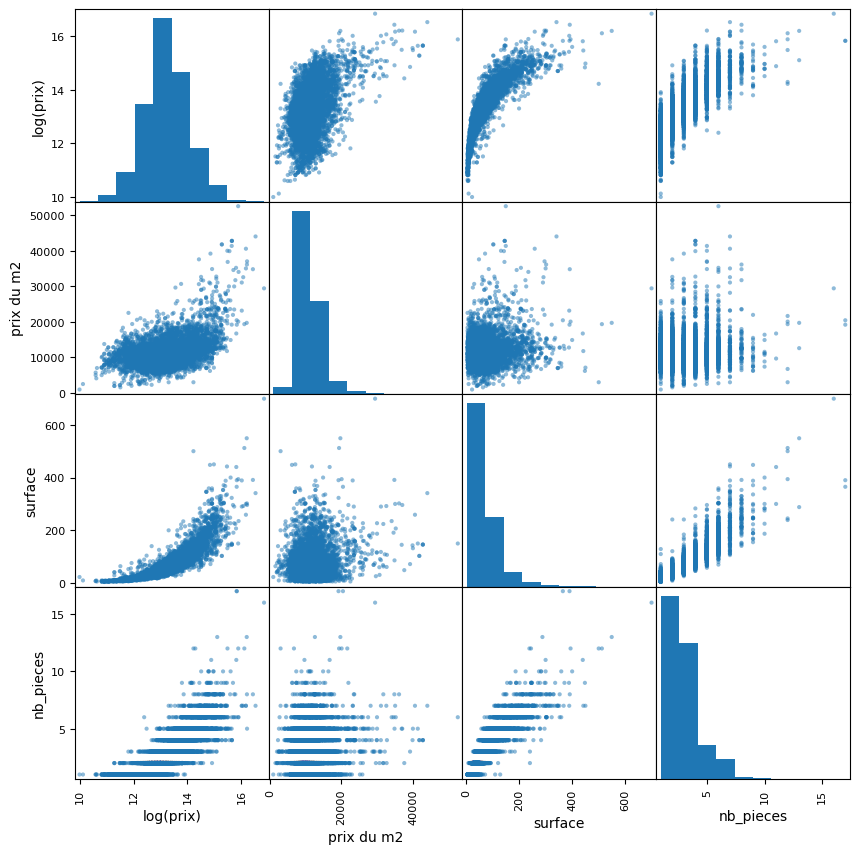

In [ ]:
listings.dropna(inplace=True)

def graph_matrice_scatter(listings: pd.DataFrame, numerical_cols: list, figsize=(10, 10)):

    pd.plotting.scatter_matrix(listings[numerical_cols], figsize=figsize)
    plt.show()

graph_matrice_scatter(listings,colonnes_numériques)

Sur ce graphique on retrouve les différentes conclusions précédemment présentées. Nous voyons en diagonale les distributions plus ou moins asymétriques. De plus on retrouve à la première ligne les corrélations positives du log(prix) aux pièces et surface et les corrélations plus flous du prix du m2 à la deuxième ligne.
Ce graphique nous permet d'identifier les points extrêmes et de juger, au cas par cas, la pertinence de les conserver dans le cadre de notre modélisation.

Premier outlier : un logement avec un prix du m2 très élevé pour son nombre de pièces et sa surface.

In [ ]:
listings.loc[listings["prix du m2"] > 50000]

,id,type,nb_pieces,loc,surface,prix,prix du m2,log(prix),surface_bracket
1231,apimo-7012481,Appartement,6,Triangle d'Or,150,7875000,52500.0,15.879204,Haut (Q3 à max)


Il s'agit donc d'un appartement à 52500€ le m2 ce qui est près de 5 fois plus que la moyenne. Cependant, cela pourrait en partie s'expliquer par le sous-quartier exclusif du "Triangle d'Or", terme caractérisant une zone géographique prestigieuse et haut de gamme dans plusieurs villes françaises. Entres autres, à Paris, le Triangle d'Or est délimité par les avenues Montaigne, des Champs-Élysées et George-V. Comparons alors ce prix pharamineux aux autres logements offerts dans le Triangle d'Or.

In [ ]:
listings.groupby('loc')['prix du m2'].mean()["Triangle d'Or"]

np.float64(21593.131878107473)

La propriété a un prix par m2 deux fois plus élevé que la moyenne du quartier qui est elle même déjà exceptionnellement haute. afin de négliger l'effet inflationniste et non représentatif de ce bien sur notre modèle, nous décidons de supprimer cette offre.   

In [ ]:
listings = listings.drop(index = listings['prix du m2'].idxmax())

Nous avons très peu de données pour les logements d'ultra luxe comportant au moins 13 chambres. De plus sur ce segment, les prix varient substantiellement car les appartements comportent des caractéristiques très exclusives qui justifient (pour certains) leur prix. Notre scraping ne nous permet cependant pas de quantifier ces caractéristiques spécifiques. Ainsi nous décidons d'enlever ces données non représentatives. (seulement 5 lignes)

In [ ]:
listings = listings[listings['nb_pieces'] < 13]

Un autre point interpelle avec une surface supérieure à 400 m2 mais un prix qui serait autour de la moyenne des 150-200 m2. 

In [ ]:
listings.loc[listings['surface']>400]

,id,type,nb_pieces,loc,surface,prix,prix du m2,log(prix),surface_bracket
4212,ag750949-445231655,Maison,12,Pasteur,500,1500000,3000.000000,14.220976,Haut (Q3 à max)
4984,immo-facile-57398126,Appartement,11,Dauphine,440,7350000,16704.545455,15.810211,Haut (Q3 à max)
5138,ag060811-446842793,Appartement,12,Chaillot,512,9900000,19335.937500,16.108045,Haut (Q3 à max)
5195,ag756771-446111090,Maison,7,Porte de Saint-Cloud,450,3200000,7111.111111,14.978661,Haut (Q3 à max)
5827,hektor-hempton-1846,Appartement,7,Dauphine,442,5200000,11764.705882,15.464169,Haut (Q3 à max)
8626,iad-france-1651337,Maison,9,Télégraphe,448,2770000,6183.035714,14.834358,Haut (Q3 à max)


On observe à la première ligne un bien à 1 500 000€ pour 500 m2 soit 3000€ du m2 ce qui semble impossible.

In [ ]:
description_listings(listings)

Le logement médian à Paris fait 54 m2, comporte 3 pièces et coûte 549000€ soit 10414€ au m2


,nb_pieces,surface,prix,prix du m2,log(prix)
count,8820.00,8820.00,8820.00,8820.00,8820.00
mean,2.87,68.09,785163.84,11004.11,13.23
std,1.58,51.86,831090.90,3500.08,0.81
min,1.00,4.00,22000.00,956.52,10.00
25%,2.00,33.00,330000.00,8950.00,12.71
50%,3.00,54.00,549000.00,10413.56,13.22
75%,4.00,87.00,900000.00,12300.00,13.71
max,12.00,512.00,15000000.00,43988.27,16.52


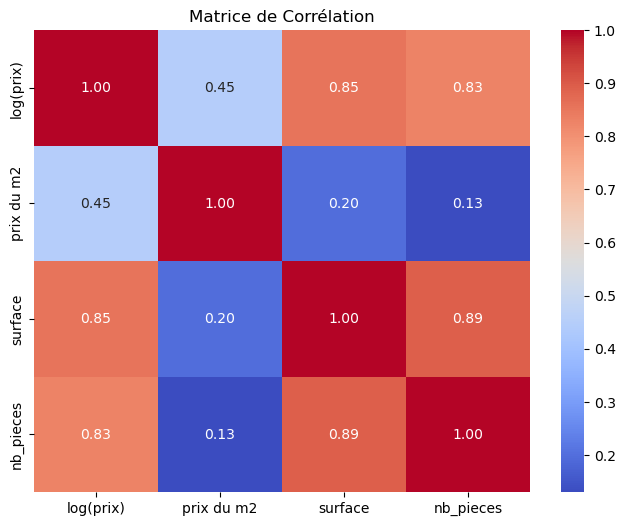

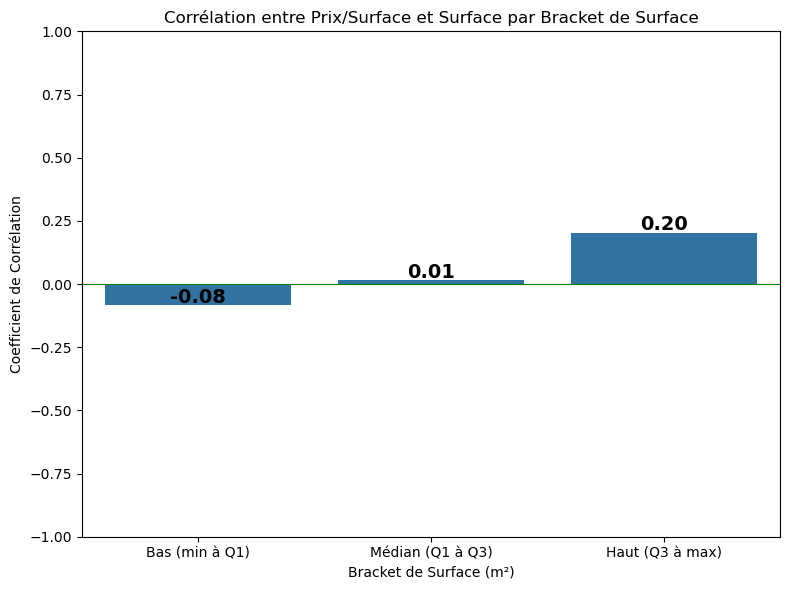

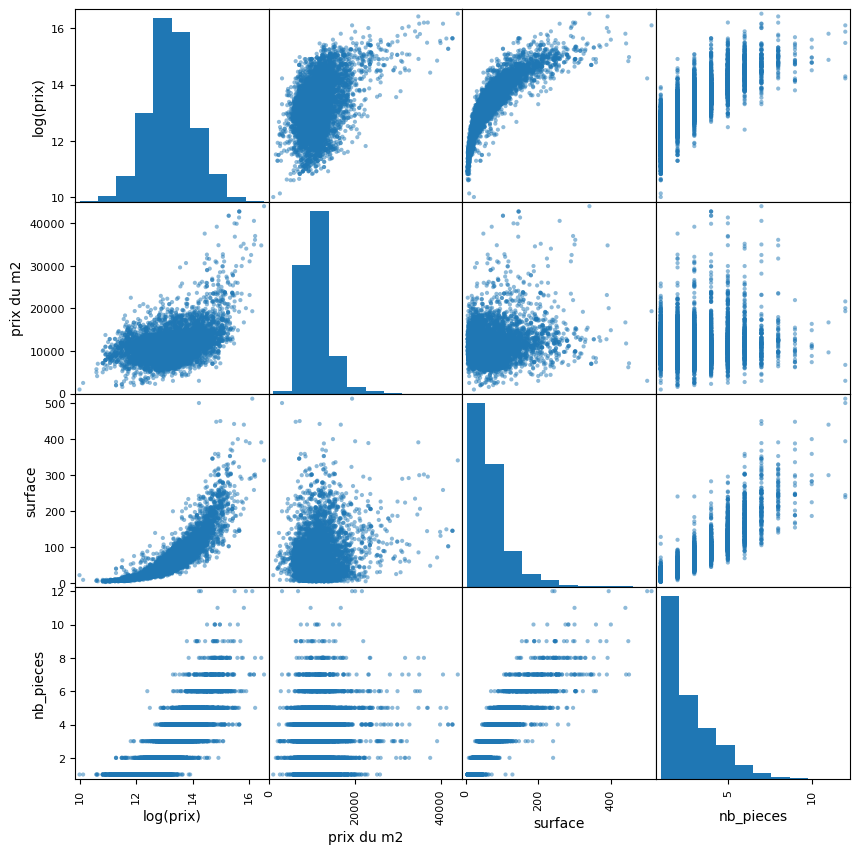

In [ ]:
graph_correlation_heatmap(listings,colonnes_numériques)
graph_bar_correlation_bracket(listings)
graph_matrice_scatter(listings, colonnes_numériques)

On observe que nos retraitements n'impactent pas les conclusions précédemment mentionnées. Les distributions restent similaires tandis que les corrélations du prix du m2 avec la surface et le nombre de pièces diminuent. En effet ces corrélations étaient en partie liées au ultra haut de gamme que nous avons réduits. 

Avant de passer à la modélisation, nous souhaitons utiliser les données de localisation que nous avons scrappées afin de réaliser une carte des niveaux de prix des différentes zones. Comme précedemment expliqué, nous avons accès aux sous-quartiers fournis par le fournisseur Kelquartier à Bien'ici. Pour obtenir une latitude et longitude, nous faisons appel aux librairies "folium" et "geopy".

In [ ]:
pip install folium
pip install geopy
import folium

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# On reprend l'ancien dataframe "listings"
# Rappel de la structure du dataframe
listings.head()

Afin de préciser nos localisations, nous rajoutons Paris après chacun d'entre elle sauf si elle le comporte déjà. Cela permettra au service de géocodage "Nominatim" (lié à OpenStreetMap) de renvoyer des coordonnées dans Paris.

In [ ]:
# On ajoute ", Paris" uniquement si "Paris" n'est pas déjà présent dans la colonne loc
listings['loc'] = listings['loc'].apply(lambda x: x if 'Paris' in x else x + ", Paris")

# Vérification en affichant à nouveau les premières lignes du DataFrame
listings.head()


,id,Type,Nb_chambre,loc,surface,prix
0,apimo-85473173,Appartement,1,"Châtelet, Paris",29,364000
1,hektor-Les-4-Quartiers-383,Appartement,1,"Châtelet, Paris",23,301000
2,hektor-PARISLUXURYHOMES-4007,Appartement,5,"Palais Royal, Paris",106,2490000
3,ag754594-448898324,Studio,1,"Saint-Germain, Paris",27,365000
4,keller-williams-1-34_1_53-180645,Appartement,2,"Vendôme, Paris",67,1190000


In [ ]:
# Uniformiser le format des localisation
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_rows', 10)
listings_ = listings.copy()
listings_[['parentheses']] = listings_['loc'].str.extract(r'\((.*?)\)')
listings_['concat'] = listings_['parentheses'].fillna('')
listings_['loc'] = listings_['concat'].where(listings_['parentheses'].notna(), listings_['loc'])
listings_.drop(columns=['parentheses', 'concat'], inplace=True)

listings_[['parentheses']] = listings_['loc'].str.extract(r'^(.*?)\s*\s-')
listings_['concat'] = listings_['parentheses'].fillna('')
listings_['loc'] = listings_['concat'].where(listings_['parentheses'].notna(), listings_['loc'])
listings_.drop(columns=['parentheses', 'concat'], inplace=True)

listings_zones=listings_["loc"].drop_duplicates().copy()
listings=listings_.copy()

In [ ]:
## Code Maxime ##

from geopy.geocoders import Nominatim
from functools import partial
geolocator = Nominatim(user_agent="testing") # création d'une instance de classe Nominatim (service de géocodage)
geocode = partial(geolocator.geocode, language="fr") # création d'une version personnalisée de géocode permettant d'envoyer des requêtes de géocodage en français
geocode_with_paris = lambda query: geolocator.geocode("%s, Paris FR" % query) # fonction qui ajoute ", Paris FR" à chaque requête afin de focaliser le service sur Paris

In [1]:
# On initialise une liste vide pour stocker les zones (la colonne loc)
tableau_zones = []

# On parcourt les zones et on les ajoute au tableau
for zone in listings_zones:
    tableau_zones.append(zone)  # Ajoute chaque zone au tableau

# On affiche le tableau final après la boucle
print("\nTableau des zones :")
tableau_zones

NameError: name 'listings_zones' is not defined

In [ ]:
# Nombre de zones dont on dispose
len(tableau_zones)

140

On cherche maintenant à obtenir des coordonnées géographiques pour chacune des zones afin de pouvoir les placer sur une carte. Comme mentionné précédemment, on utilise le service de géocodage Nominatim.

In [ ]:
from geopy.geocoders import Nominatim
import time

# Créer un objet géocodeur Nominatim pour extraire la longitude et la latitude de chaque zone
geolocator = Nominatim(user_agent="my_geocoder")

# Fonction pour obtenir les coordonnées géographiques (longitude et latitude) d'une adresse
def obtenir_coordonnees(tableau_zones):
    try:
        location = geolocator.geocode(tableau_zones, timeout=5)
        if location:
            return location.latitude, location.longitude
        else:
            return None, None
    except Exception as e:
        print(f"Erreur pour {tableau_zones}: {e}")
        return None, None


# Créer un dictionnaire pour stocker les adresses et leurs coordonnées géographiques
coordonnees_dict = {}

for zone in tableau_zones:
    lat, lon = obtenir_coordonnees(zone)  # Passer 'zone_paris' à la fonction
    coordonnees_dict[zone] = (lat, lon)   # Utiliser 'zone_paris' comme clé
    
    # Pause pour éviter un blocage par le serveur
    time.sleep(1)

# Créer une liste pour stocker les informations des adresses
coordonnees = []

# Afficher et stocker les coordonnéesde toutes les zones
print("\nCoordonnées des adresses :")
for zone, coord in coordonnees_dict.items():
    print(f"Adresse: {zone}, Latitude: {coord[0]}, Longitude: {coord[1]}")
    coordonnees.append({"adresse": zone, "latitude": coord[0], "longitude": coord[1]})  # Stocker les données

# Afficher le contenu de coordonnees
print("\nContenu de coordonnees2 :")
for item in coordonnees:
    print(item)


Coordonnées des 3 premières adresses :
Adresse: Châtelet, Paris, Latitude: 48.8568781, Longitude: 2.3483592
Adresse: Palais Royal, Paris, Latitude: 48.863584700000004, Longitude: 2.3362042200938715
Adresse: Saint-Germain, Paris, Latitude: 48.85655255, Longitude: 2.333331104782813
Adresse: Vendôme, Paris, Latitude: 48.86690005, Longitude: 2.3285489140926545
Adresse: Gaillon, Paris, Latitude: 48.869135150000005, Longitude: 2.332908770335507
Adresse: Saint-Thomas d'Aquin, Paris, Latitude: 48.85424375, Longitude: 2.3268829064838443
Adresse: 75001 Paris 1er, Latitude: 48.8646144, Longitude: 2.334396
Adresse: Sentier, Paris, Latitude: 48.867518, Longitude: 2.3465656
Adresse: Montorgueil, Paris, Latitude: 48.8641678, Longitude: 2.3467038
Adresse: 75002 Paris 2e, Latitude: 48.868743, Longitude: 2.341688
Adresse: Arts-et-Métiers, Paris, Latitude: 48.8654718, Longitude: 2.3561116
Adresse: Sainte-Avoye, Paris, Latitude: 48.862699750000004, Longitude: 2.354135471358302
Adresse: Archives, Paris, L

In [ ]:
# On affiche le tableau avec les coordonnées
coordonnees

[{'adresse': 'Châtelet, Paris',
  'latitude': 48.8568781,
  'longitude': 2.3483592},
 {'adresse': 'Palais Royal, Paris',
  'latitude': 48.863584700000004,
  'longitude': 2.3362042200938715},
 {'adresse': 'Saint-Germain, Paris',
  'latitude': 48.85655255,
  'longitude': 2.333331104782813},
 {'adresse': 'Vendôme, Paris',
  'latitude': 48.86690005,
  'longitude': 2.3285489140926545},
 {'adresse': 'Gaillon, Paris',
  'latitude': 48.869135150000005,
  'longitude': 2.332908770335507},
 {'adresse': "Saint-Thomas d'Aquin, Paris",
  'latitude': 48.85424375,
  'longitude': 2.3268829064838443},
 {'adresse': '75001 Paris 1er', 'latitude': 48.8646144, 'longitude': 2.334396},
 {'adresse': 'Sentier, Paris', 'latitude': 48.867518, 'longitude': 2.3465656},
 {'adresse': 'Montorgueil, Paris',
  'latitude': 48.8641678,
  'longitude': 2.3467038},
 {'adresse': '75002 Paris 2e', 'latitude': 48.868743, 'longitude': 2.341688},
 {'adresse': 'Arts-et-Métiers, Paris',
  'latitude': 48.8654718,
  'longitude': 2.35

In [ ]:
# On affiche la taille du tableau
len(coordonnees)

140

In [ ]:
# Diviser les adresses en fonction des noms spécifiques ou vagues
noms_specifiques = []
noms_vagues = []

for item in coordonnees:
    if any(char.isdigit() for char in item['adresse']):  # Vérifier si l'adresse contient des chiffres (arrondissements)
        noms_vagues.append(item)
    else:
        noms_specifiques.append(item)

print(noms_specifiques)
print(noms_vagues)

[{'adresse': 'Châtelet, Paris', 'latitude': 48.8568781, 'longitude': 2.3483592}, {'adresse': 'Palais Royal, Paris', 'latitude': 48.863584700000004, 'longitude': 2.3362042200938715}, {'adresse': 'Saint-Germain, Paris', 'latitude': 48.85655255, 'longitude': 2.333331104782813}, {'adresse': 'Vendôme, Paris', 'latitude': 48.86690005, 'longitude': 2.3285489140926545}, {'adresse': 'Gaillon, Paris', 'latitude': 48.869135150000005, 'longitude': 2.332908770335507}, {'adresse': "Saint-Thomas d'Aquin, Paris", 'latitude': 48.85424375, 'longitude': 2.3268829064838443}, {'adresse': 'Sentier, Paris', 'latitude': 48.867518, 'longitude': 2.3465656}, {'adresse': 'Montorgueil, Paris', 'latitude': 48.8641678, 'longitude': 2.3467038}, {'adresse': 'Arts-et-Métiers, Paris', 'latitude': 48.8654718, 'longitude': 2.3561116}, {'adresse': 'Sainte-Avoye, Paris', 'latitude': 48.862699750000004, 'longitude': 2.354135471358302}, {'adresse': 'Archives, Paris', 'latitude': 48.8596256, 'longitude': 2.362541376680502}, {'

In [ ]:
### CREATION DE LA CARTE ###

# Initialiser la carte centrée sur Paris
carte = folium.Map(location=[48.8566, 2.3522], zoom_start=12)

# Ajouter des points sur la carte pour les adresses avec coordonnées
for lieu in noms_specifiques :          # J'affiche seulement les adresses spécifiques (pas les vagues pour eviter tout problème parce qu'elles n'apparaissent pas au bond endroit sur la carte...)
    if lieu["latitude"] is not None and lieu["longitude"] is not None:
        folium.Marker(
            location=[lieu["latitude"], lieu["longitude"]],
            popup=lieu["adresse"],      # Texte affiché lorsqu'on clique sur le point
            icon=folium.Icon(color="blue", icon="info-sign")
        ).add_to(carte)

# Sauvegarder la carte dans un fichier HTML
carte.save("carte_paris_points.html")
print("Carte créée : carte_paris_points.html")

Carte créée : carte_paris_points.html


In [ ]:
## Affichage de la carte
carte

In [ ]:
# Regrouper par 'loc' et calculer la moyenne des prix, des surfaces et le nombre d'annonces
resultat = listings.groupby('loc', as_index=False).agg(
    moyenne_prix=('prix', 'mean'),      # Moyenne des prix
    moyenne_surface=('surface', 'mean'),  # Moyenne des surfaces
    nombre_annonces=('prix', 'size')   # Nombre d'annonces (compte les lignes)
)

# Calculer la moyenne des prix au m²
resultat['prix_m2'] = resultat['moyenne_prix'] / resultat['moyenne_surface']

# Supprimer les colonnes intermédiaires si elles ne sont pas nécessaires
resultat = resultat[['loc', 'prix_m2', 'nombre_annonces']]  # Garder uniquement loc, prix_m2 et nombre d'annonces

# Vérification des résultats
print(resultat)

                         loc       prix_m2  nombre_annonces
0                75000 Paris   4456.521739                1
1            75001 Paris 1er  20959.770115                3
2             75002 Paris 2e  12623.655914                3
3             75003 Paris 3e  10774.245115                6
4             75004 Paris 4e  21924.863388                3
..                       ...           ...              ...
135      Val de Grâce, Paris  13455.888651                9
136  Vallée de Fecamp, Paris   8803.143394               98
137         Vaugirard, Paris  10369.205115              206
138           Vendôme, Paris  17642.301545               19
139            Violet, Paris  11067.360796               53

[140 rows x 3 columns]


In [ ]:
# Convertir les coordonnées en DataFrame
coord_listings = pd.DataFrame(coordonnees)

# Fusionner les deux DataFrames
resultat = resultat.merge(coord_listings[['adresse', 'latitude', 'longitude']], 
                          left_on='loc', 
                          right_on='adresse', 
                          how='left')

# Supprimer la colonne 'adresse' qui est redondante après la fusion
resultat.drop(columns=['adresse'], inplace=True)

# Vérification des résultats
print(resultat)

                         loc       prix_m2  nombre_annonces   latitude  \
0                75000 Paris   4456.521739                1  48.858890   
1            75001 Paris 1er  20959.770115                3  48.864614   
2             75002 Paris 2e  12623.655914                3  48.868743   
3             75003 Paris 3e  10774.245115                6  48.864212   
4             75004 Paris 4e  21924.863388                3  48.856202   
..                       ...           ...              ...        ...   
135      Val de Grâce, Paris  13455.888651                9  48.842243   
136  Vallée de Fecamp, Paris   8803.143394               98  48.834826   
137         Vaugirard, Paris  10369.205115              206  48.839587   
138           Vendôme, Paris  17642.301545               19  48.866900   
139            Violet, Paris  11067.360796               53  48.844960   

     longitude  
0     2.320041  
1     2.334396  
2     2.341688  
3     2.360936  
4     2.355619  
..       

In [ ]:
# Supprimer les lignes contenant des NaN dans le DataFrame 'resultat'
resultat = resultat.dropna()

# Vérification des résultats
print("DataFrame après suppression des NaN :")
print(resultat)

DataFrame après suppression des NaN :
                         loc       prix_m2  nombre_annonces   latitude  \
0                75000 Paris   4456.521739                1  48.858890   
1            75001 Paris 1er  20959.770115                3  48.864614   
2             75002 Paris 2e  12623.655914                3  48.868743   
3             75003 Paris 3e  10774.245115                6  48.864212   
4             75004 Paris 4e  21924.863388                3  48.856202   
..                       ...           ...              ...        ...   
135      Val de Grâce, Paris  13455.888651                9  48.842243   
136  Vallée de Fecamp, Paris   8803.143394               98  48.834826   
137         Vaugirard, Paris  10369.205115              206  48.839587   
138           Vendôme, Paris  17642.301545               19  48.866900   
139            Violet, Paris  11067.360796               53  48.844960   

     longitude  
0     2.320041  
1     2.334396  
2     2.341688  
3    

In [ ]:
# Normaliser les tailles des points en fonction du nombre d'annonces
min_radius = 5
max_radius = 20

def scale_radius(nombre_annonces):
    return min_radius + (max_radius - min_radius) * (nombre_annonces - resultat['nombre_annonces'].min()) / (resultat['nombre_annonces'].max() - resultat['nombre_annonces'].min())

# Création de la carte
carte = folium.Map(location=[48.8566, 2.3522], zoom_start=12)

# Ajout des points
for _, row in resultat.iterrows():
    couleur = prix_m2_to_color(row['prix_m2'])  # Couleur basée sur le prix/m²
    radius = scale_radius(row['nombre_annonces'])  # Taille basée sur le nombre d'annonces
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=radius,  # Taille des points
        color='black',  # Contour noir
        fill=True,
        fill_color=couleur,  # Remplissage rouge
        fill_opacity=0.9,
        popup=f"{row['loc']}<br>Prix/m² : {row['prix_m2']:.2f} €<br>Nombre d'annonces : {row['nombre_annonces']}"
    ).add_to(carte)

# Sauvegarder la carte
carte.save("carte_prix_m2_taille.html")
print("Carte créée : carte_prix_m2_taille.html")

Carte créée : carte_prix_m2_taille.html


In [ ]:
# Plus la couleur est clair plus le prix/m² est faible. 
# Inversement, plus la couleur est élevée plus le prix/m² est élevée. 
# Afficher la carte : 
carte